This notebook contains python codes to run strontium isotope box model

In [1]:
# import python module
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Functions
# ---------
# Isotopic mass balace equation
def simSr(jr, rr, rsw, jh, rh, n):
    """

    Strontium isotopic mass balance.

    Parameters
    ----------
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSr : float
        Strontium isotopic ratio of seawater.

    """
    rSr = (jr*(rr-rsw) + jh*(rh-rsw)) / n
    return rSr

# Function to run model
def run_sim(nt, dt, age, jr, rr, rsw, jh, rh, n):
    """
    
    Solving diff. equations defined in simSr() using the forward Euler method.

    Parameters
    ----------
    nt : int
        number of time steps to run model
    dt : float
        the size of each time step
    age : float
        age in million years
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSw : float
        Strontium isotopic ratio of seawater.
    grad : float
          gradient of rSw  
        
    """
    rsw0 = (jr[0]*rr[0] + jh[0]*rh[0])/(jr[0]+jh[0])
    rsw[0] = rsw0
    
    for i in range(nt-1):
        rsw[i+1] = rsw[i] + simSr(jr[i], rr[i], rsw[i], jh[i], rh[i], n[i])*dt
    
    grad = np.diff(rsw)/np.diff(age)
    grad = np.append(grad, grad[-1])
   
    return rsw, grad

### Define time
This block of code creates arrays to run the simulation.

In [3]:
# Define array of time
# --------------------
tmin = 487      # ~ base of Ordovician in Ma (GTS2020)
tmax = 443      # ~ base of Silurian in Ma (GST2020)
nt = 100000     # number of steps
dt = (tmin - tmax)*1e6 / nt    # size of each step
time = np.linspace(0, (tmin-tmax)*1e6, nt)    # time array
age = np.linspace(tmin, tmax, nt)             # age array (in Myr)

In [4]:
# Initial values and parameters
# -----------------------------
# Riverine flux
Jriv0 = 3e10
Jriv = np.ones(nt) * Jriv0

# Riverine isotopic ratio
Rriv0 = 0.7111
Rriv = np.ones(nt) * Rriv0

# Hydrothermal fluxes are calculated 
# Axial (crestal) hydrothermal flux
#Jhcrest0 = 7.50e9
#Jhcrest = np.ones(nt) * Jhcrest0

# Off-axis (flank) hydrothermal flux
#Jhflank0 =7.50e9
#Jhflank = np.ones(nt) * Jhflank0

# Total hydrothermal flux
#Jh0 = Jhflank0 + Jhcrest0
#Jh = np.zeros(nt)
#Jh = Jhflank + Jhcrest

Jh0 = 8e9
Jh = np.ones(nt)*1.05e10

# Hydrothermal isotopic ratio
Rh0 = 0.7028
Rh = np.ones(nt) * Rh0

# Array to store isotopic ratio of seawater and rate of change
Rsw = np.zeros(nt)
GradSr = np.zeros(nt)

# Reservoir size
N = np.ones(nt) * 1.27e17

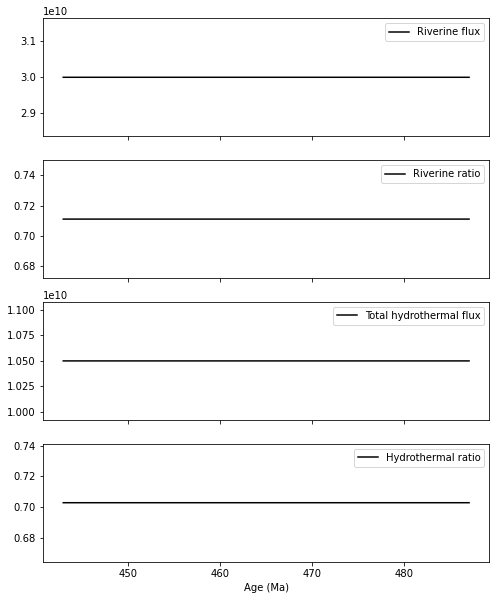

In [5]:
params = {
    'Riverine flux':Jriv, 
    'Riverine ratio':Rriv, 
    'Total hydrothermal flux':Jh,
    'Hydrothermal ratio':Rh}

fig, ax = plt.subplots(len(params), figsize=(8,10), sharex=True)

for index, (key, value), in enumerate(params.items()):
    ax[index].plot(age, value, c='k',label=key)
    ax[index].legend(loc='upper right')
    ax[-1].set_xlabel('Age (Ma)')

#plt.savefig("../Figure/params.png")
#plt.savefig("../Figure/params.svg")

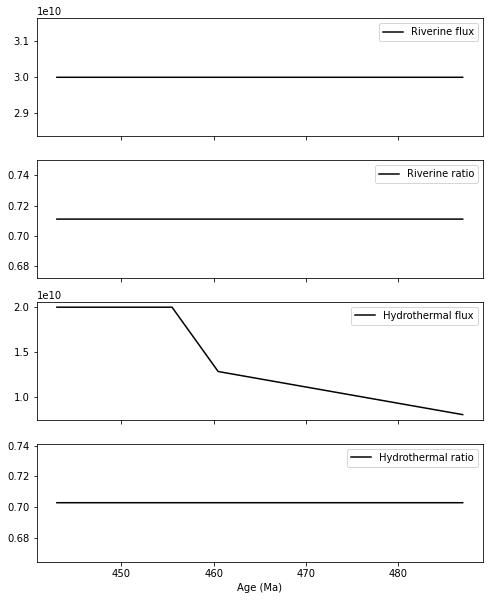

In [6]:
# System perturbation
# -------------------
# timing of perturbation in Ma
start_age = 460 #i.e. the inflection point
stop_age = 455 #where the flux stabilizes into a new baseline

# convert age to array index
start = np.where(np.round(age)==start_age)[0][0]
stop = np.where(np.round(age)==stop_age)[0][0]

# perturb the system by increasing hydrothermal flux
f1 = 1.6#times the baseline
Jh[:start] = np.linspace(Jh0, Jh0*f1, start)

#Jhflank[:start] = np.linspace(Jhflank0, Jhflank0*f1, start)
#Jhcrest[:start] = np.linspace(Jhcrest0, Jhcrest0*f1, start)

f2 = 2.5 #times the inflection point flux
Jh[start:stop] = np.linspace(Jh0*f1, Jh0*f2, (stop-start))
Jh[stop:] = Jh0*f2

#Jhflank[start:stop] = np.linspace(Jhflank[start-1], Jhflank[start-1]*f2, (stop-start))
#Jhflank[stop:] = np.ones(len(Jhflank)-stop) * (Jhflank[stop-1])
#Jhcrest[start:stop] = np.linspace(Jhcrest[start-1], Jhcrest[start-1]*f2, (stop-start))
#Jhcrest[stop:] = np.ones(len(Jhcrest)-stop) * (Jhcrest[stop-1])

#Jh = Jhflank + Jhcrest

params = {
    'Riverine flux':Jriv, 
    'Riverine ratio':Rriv, 
    'Hydrothermal flux':Jh,
    'Hydrothermal ratio':Rh}

fig, ax = plt.subplots(len(params), figsize=(8,10), sharex=True)
for index, (key, value), in enumerate(params.items()):
    ax[index].plot(age, value, c='k',label=key)
    ax[index].legend(loc='upper right')
    ax[-1].set_xlabel('Age (Ma)')

plt.savefig("../Figure/Params_perturbed_S8.png")
plt.savefig("../Figure/Params_perturbed_S8.svg")

In [7]:
# Run the model
# -------------
Rsw, GradSr = run_sim(nt, dt, age, Jriv, Rriv, Rsw, Jh, Rh, N)

### Constraining changes in hydrothermal activities using long-term sea-level change

In this model we hypothesize a role for hydrothermal activities in perturbing global Sr cycles during the Ordovician. To model changes in hydrothermal activities we used eustatic sea level curves, assuming the long-term changes in sea levels are mainly controlled by changes in ocean basin geometry, which in turn depends on the rate of sea floor spreading.

Sea level curves were taken from Haq and Schutter (2008), and recalibrated to Geologic Time Scale 2020 (Goldman et al., 2020).

In [8]:
# load sea level data
ordosealevel = np.load("../Data/OrdoSeaLevel.npz")['SeaLevel']
ordoseaage = np.load("../Data/OrdoSeaLevel.npz")['age']

array size = 100000


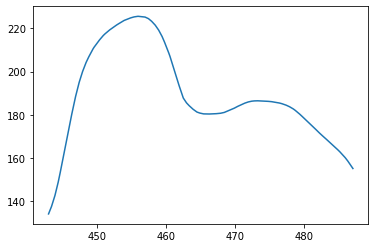

In [9]:
# resample data to fit our modeling array
from scipy import interpolate

f = interpolate.interp1d(ordoseaage, ordosealevel)

sealevel = f(age)
plt.plot(age, sealevel)
print('array size =',len(sealevel))

max  : 1.4536080670085052
min  : 0.8646907216494846
mean : 1.221990718759185


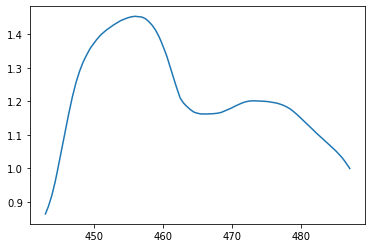

In [10]:
# normalize sea level relative to mean
sl_norm = sealevel / sealevel.mean()
sl_norm_min = sealevel / sealevel[0]

plt.plot(age, sl_norm_min)
print('max  :', sl_norm_min.max())
print('min  :', sl_norm_min.min())
print('mean :', sl_norm_min.mean())

In [11]:
Jh_sl = sl_norm * Jh0

In [12]:
Rsw_sl = np.zeros(nt)
Rsw_sl, GradSr_sl = run_sim(nt, dt, age, Jriv, Rriv, Rsw_sl, Jh_sl, Rh, N)

# Final Figure

NameError: name 'loess' is not defined

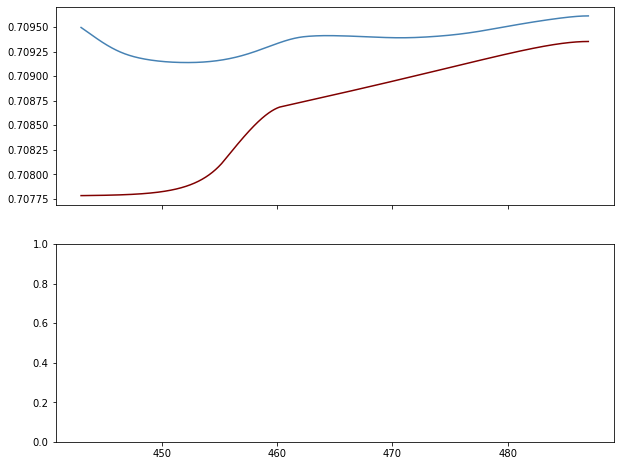

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)


ax1.plot(age, Rsw, c='maroon', label="Standard Model")
ax1.plot(age, Rsw_sl, c='steelblue', label="Sea Level Model")
ax1.plot(loess['age'], loess['LOESS'], c='olivedrab', label='LOESS Curve')
ax1.scatter(SrOrdo['Age20'], SrOrdo['Sr'], c='olivedrab', label='Sr Conodont Data', alpha=0.4)
ax1.set_ylabel('Seawater $^{87}Sr/^{86}Sr$')
ax1.invert_xaxis()
ax1.legend(loc='lower left', edgecolor='None')

ax2.plot(age, GradSr*1e5, color='maroon',label="Standard Model")
ax2.plot(age, GradSr_sl*1e5, color='steelblue',label="Sea Level Model")
ax2.plot(loess['age'], loess['LOESS_1D']*1e5, c='olivedrab', label='LOESS Curve Gradient')
ax2.set_ylabel('Rate of $^{87}Sr/^{86}Sr$ Change ($10^{-5}$/yr)')
ax2.legend(loc='upper left', edgecolor='None')